In [123]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [124]:
def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.show()

## Task 1. Hough Transform for Circles

Read the image billiards.png

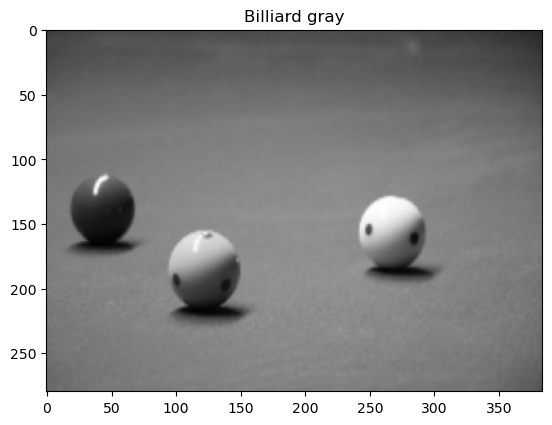

Billiard shape: (280, 384)


In [125]:
# set image path
billiards_path = './images/billiards.png'
# read imgs
img_billiards = cv.imread(billiards_path, cv.IMREAD_GRAYSCALE)

display_image('Billiard gray', img_billiards)
print(f"Billiard shape: {img_billiards.shape}")

(a) Detect the circles by a Hough transform using cv2.HoughCircles.
Visualize the detections by drawing circles on the image.

Lets use Canny Edge detector to extract the object shapes from the image

In [126]:
# Apply Hough transform to greyscale image
circles = cv.HoughCircles(img_billiards,cv.HOUGH_GRADIENT,1,15,
                     param1=60,param2=30,minRadius=10,maxRadius=100)

circles = np.uint8(np.around(circles))

[[[ 10 154  25]
  [ 44 140  24]
  [122 192  24]]]


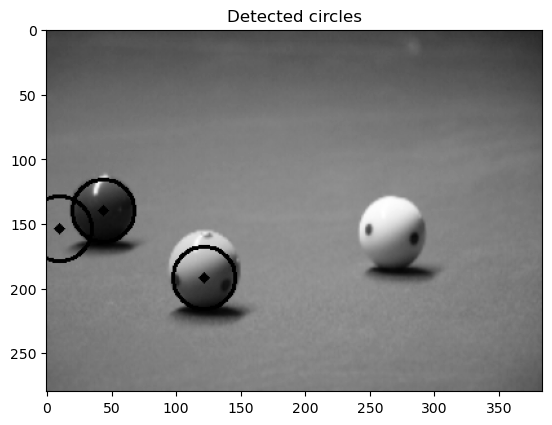

In [127]:
img_billiards_copy = img_billiards.copy()
# Draw the circles
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(img_billiards_copy,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(img_billiards_copy,(i[0],i[1]),2,(0,0,255),3)
print(circles)

display_image('Detected circles', img_billiards_copy)

(b) Implement the function myHoughCircles and use it to detect the circles.
Visualize the detections and comment on how the result varies with different
parameters.

First apply a Gaussian Blur, then Canny edge detector

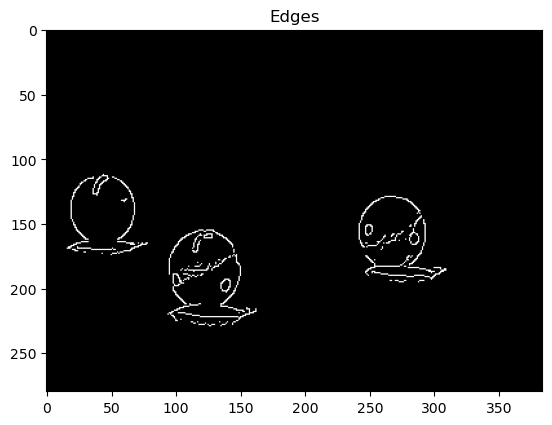

In [128]:
img_blur = cv.GaussianBlur(img_billiards, (3, 3), 0)
edges = cv.Canny(img_blur, 60, 30).astype(np.uint8)
display_image('Edges', edges)

In [129]:
def myHoughCircles(edges, minRadius, maxRadius, threshold, minDist):
    """
    Your implementation of HoughCircles
    :edges: single-channel binary source image (e.g: edges)
    :minRadius: minimum circle radius
    :maxRadius: maximum circle radius
    :param threshold: minimum number of votes to consider a detection
    :minDist: minimum distance between two centers of the detected circles. 
    :return: list of detected circles as (a, b, r) triplet
    """
    accumulator = np.zeros((edges.shape[0], edges.shape[1], maxRadius)).astype(np.float64)
    edges_points = np.array(np.nonzero(edges))
    detected_circles = []
        
    for x in range(edges_points.shape[1]):
        for r in range(minRadius, maxRadius):
            for theta in range(0, 360):
                a = int(edges_points[0][x] - r * np.cos(theta*np.pi/180.))
                b = int(edges_points[1][x] - r * np.sin(theta*np.pi/180.))
                
                try:

                    accumulator[a][b][r] += 1
                except:
                    break

    accumulator_copy = accumulator.copy()
    
    finished = False
    while not finished:
        idx = np.argmax(accumulator_copy)

        a, b, r = np.unravel_index(idx, accumulator_copy.shape)

        if accumulator_copy[a, b, r] > threshold:
            # check if the circle is already detected
            already_detected = False
            for deteted_circle in detected_circles:
                if np.linalg.norm(np.array([b, a]) - np.array(deteted_circle[:2])) < minDist:
                    already_detected = True
                    break
            if not already_detected:
                detected_circles.append([b, a, r])
            
        else:
            finished = True

        accumulator_copy[a, b, r] = 0
    
    return [detected_circles], accumulator

My solution is very slow (because of for-loops). It takes about 2:45 minutes. I am not sure how to vectorize it :(

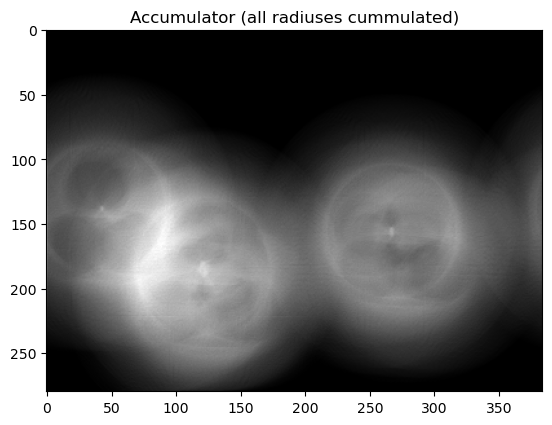

In [130]:
# Apply My Hough transform to edges image
minRadius = 25
maxRadius = 80
minDist = edges.shape[0]/8
threshold = 78
my_circles, accumulator = myHoughCircles(edges, minRadius=minRadius,maxRadius=maxRadius, threshold=threshold, minDist=minDist)

my_circles = np.uint8(np.around(my_circles))

display_image("Accumulator (all radiuses cummulated)", accumulator.sum(axis=2))

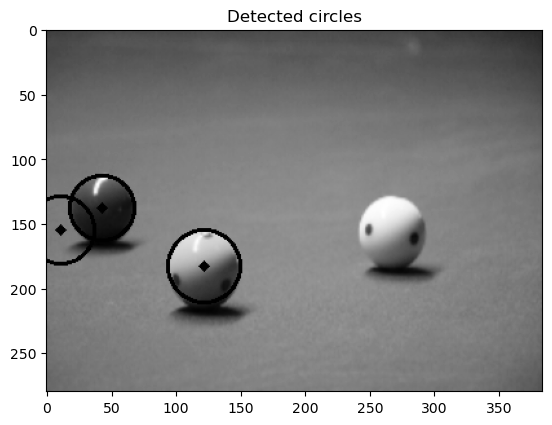

In [131]:
img_billiards_copy = img_billiards.copy()
# Draw the circles
for i in my_circles[0,:]:
    # draw the outer circle
    cv.circle(img_billiards_copy,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(img_billiards_copy,(i[0],i[1]),2,(0,0,255),3)

display_image('Detected circles', img_billiards_copy)

The results of my algorithm and of opencv are very similar. But they both do not recognize the rightmost ball. Why? 

## 2. Mean Shift

Read the image line.png and use the given function houghLines to get the accumulator of the detected lines in the image. Then implement the mean shift
algorithm to find the peaks in the accumulator. Visualize the accumulator and the
lines corresponding to the peaks.

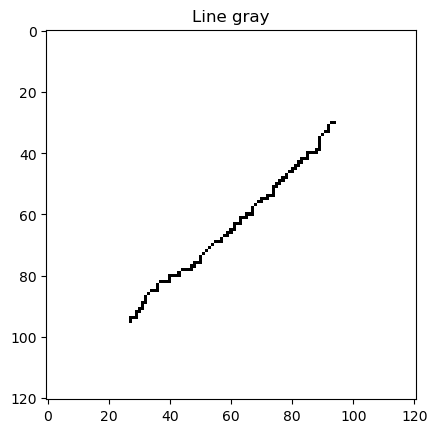

Line shape: (121, 121)


In [132]:
# set image path
line_path = './images/line.png'
# read imgs
img_line = cv.imread(line_path)
img_line_gray = cv.cvtColor(img_line, cv.COLOR_BGR2GRAY)

display_image('Line gray', img_line_gray)
print(f"Line shape: {img_line_gray.shape}")

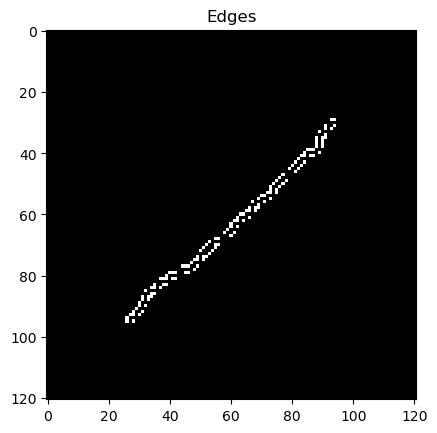

In [133]:
edges_line = cv.Canny(img_line_gray, 75, 150).astype(np.uint8)
display_image('Edges', edges_line)

In [134]:
def houghLines(img_edges, d_resolution, theta_step_sz, threshold):
    """
    Implementation of HoughLines
    :param img_edges: single-channel binary source image (e.g: edges)
    :param d_resolution: the resolution for the distance parameter
    :param theta_step_sz: the resolution for the angle parameter
    :param threshold: minimum number of votes to consider a detection
    :return: list of detected lines as (d, theta) pairs and the accumulator
    """
    accumulator = np.zeros((int(180/theta_step_sz), int(np.linalg.norm(img_edges.shape)/d_resolution)))
    edges_points = np.array(np.nonzero(img_edges))

    for i in range(edges_points.shape[1]):
        for theta in range(0, 180, theta_step_sz):
            d = int((edges_points[1][i] * np.cos(theta*np.pi/180.) + edges_points[0][i] * np.sin(theta*np.pi/180.)) / d_resolution)
            accumulator[int(theta/theta_step_sz), d] += 1
    
    accumulator_copy = accumulator
    detected_lines = []
    finished = False
    while not finished:
        idx = np.argmax(accumulator_copy)
        theta, d = np.unravel_index(idx, accumulator_copy.shape)

        if accumulator_copy[theta, d] > threshold:
            detected_lines.append([d * d_resolution, theta * theta_step_sz * np.pi / 180.])
        else:
            finished = True

        accumulator_copy[theta, d] = 0

    return detected_lines, accumulator

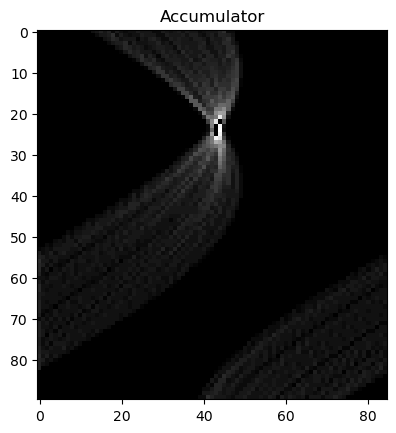

In [135]:
d_resolution = 2
theta_step_sz = 2
_, accumulator_line = houghLines(edges_line, d_resolution, theta_step_sz, 50)

display_image('Accumulator', accumulator_line)

Let's create a Normal Kernel for Kernel Density estimation

In [136]:
def get_gausian_kernel(radius):
    """
    Returns a 2D gaussian kernel
    :param radius: the radius of the kernel
    :return: 2D gaussian kernel
    """
    center = (radius, radius)
    kernel = np.zeros((2*radius+1, 2*radius+1))
    for x in range(-radius, radius+1):
        for y in range(-radius, radius+1):
            kernel[x+radius, y+radius] = np.exp(-(np.linalg.norm([x , y])**2) / (2.*radius))
    return kernel 

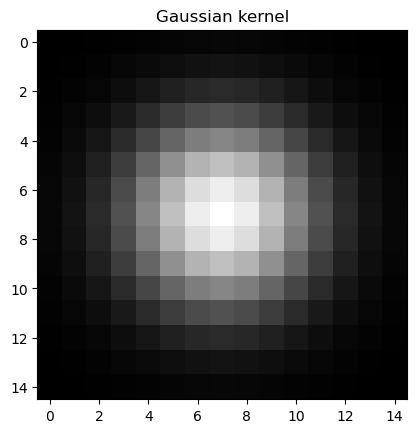

In [137]:
radius = 7
kernel = get_gausian_kernel(radius)
display_image('Gaussian kernel', kernel)

In [138]:
print(kernel.min())

0.0009118819655545162


In [139]:
def createMask(window):
    mask = np.zeros((2 * window + 1, 2 * window + 1))
    center = (window, window)
    for i in range(2 * window + 1):
        for j in range(2 * window + 1):
            if np.linalg.norm([i - center[0], j - center[1]]) < window:
                mask[i, j] = np.exp(-(np.linalg.norm([i - center[0], j - center[1]])**2) / (2.*window))
    return mask

kernel = createMask(radius)

In [140]:
def meanShift(accumulator_padded, radius, kernel, x, y):
    """
    Implementation of mean shift algorithm
    :param accumulator_padded: the accumulator with padding
    :param radius: the radius of the kernel
    :param kernel: the kernel
    :param x: the x coordinate of the peak
    :param y: the y coordinate of the peak
    :return: the new peak coordinates
    """

    converge = False
    i = 0
    while not converge and i < 100:
        i += 1
        sum_weighted = np.sum(kernel * accumulator_padded[y-radius:y+radius+1, x-radius:x+radius+1])
        sum_x = np.sum(np.arange(x-radius, x+radius+1) * accumulator_padded[y-radius:y+radius+1, x-radius:x+radius+1] * kernel)
        sum_y = np.sum(np.arange(y-radius, y+radius+1) * accumulator_padded[y-radius:y+radius+1, x-radius:x+radius+1] * kernel.T)
        new_x = int(np.round(sum_x / sum_weighted))
        new_y = int(np.round(sum_y / sum_weighted))
        if (new_x == x and new_y == y):
            converge = True
        x = new_x
        y = new_y
    return x, y, sum_weighted

In [141]:
def peaks2lines(peaks, d_resolution, theta_step_sz):
    """
    Converts the peaks to lines
    :param peaks: the peaks
    :param d_resolution: the d resolution
    :param theta_step_sz: the theta step size
    :return: array of lines as 4d array of the form [x1, y1, x2, y2]
    """
    lines = []
    for peak in peaks:
        d = peak[0] * d_resolution
        theta = peak[1] * theta_step_sz * np.pi / 180.
        x1 = 0
        y1 = int(d / np.sin(theta))
        x2 = int(d / np.cos(theta))
        y2 = 0
        lines.append([x1, y1, x2, y2])
    return lines

Found 2 peaks
Peaks: [[44, 24], [44, 23]]
Found lines: [[0, 118, 131, 0], [0, 122, 126, 0]]


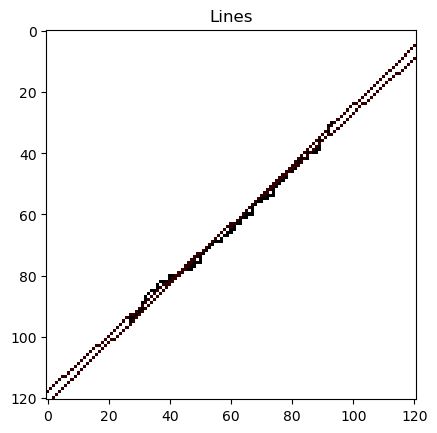

In [142]:
threshold = 415
peaks = []

accumulator_padded = accumulator_line.copy()
# add padding to the accumulator = radius to avoid out of bounds
accumulator_padded = np.pad(accumulator_padded, radius, 'constant', constant_values=0)

acc_votes_y, acc_votes_x = np.nonzero(accumulator_padded)
for idx in range(0, len(acc_votes_y), radius):
    y1 = acc_votes_y[idx]
    x1 = acc_votes_x[idx]
    
    try:
        x2, y2, sum_weighted = meanShift(accumulator_padded, radius, kernel, x1, y1)
    except:
        break

    if sum_weighted > threshold:
        x2 = int(round(x2))
        y2 = int(round(y2))
        if [x2, y2] not in peaks:
            peaks.append([x2, y2])

pruned_peaks = []
for p in peaks:
    neighbors_arr = accumulator_padded[p[1] - radius: p[1] + radius, p[0] - radius: p[0] + radius]
    y, x = np.unravel_index(np.argmax(neighbors_arr, axis=None), neighbors_arr.shape)
    if [x - 2 * radius + p[0], y - 2 * radius + p[1]] not in pruned_peaks:
        pruned_peaks.append([x - 2 * radius + p[0], y - 2 * radius + p[1]])

print(f"Found {len(pruned_peaks)} peaks")
print(f"Peaks: {pruned_peaks}")

lines = peaks2lines(pruned_peaks, d_resolution, theta_step_sz)
print(f"Found lines: {lines}")
img_line_copy = img_line.copy()
for l in lines:
    cv.line(img_line_copy, (l[0], l[1]), (l[2], l[3]), 50, 1)

display_image( "Lines", img_line_copy)

## Task 3 K-Means

Implement the function myKmeans and then use it to segment the image flower.png  based on:

(a)  Intensity,

(b)  Color,

(c)  Intensity and (properly scaled) image position.



In [143]:
import random


def myKmeans(data, k):
    """
    Your implementation of k-means algorithm
    :param data: list of data points to cluster
    :param k: number of clusters
    :return: centers and list of indices that store the cluster index for each data point
    """
    centers = np.zeros((k, data.shape[1]))
    index = np.zeros(data.shape[0], dtype=int)
    clusters = [[] for i in range(k)]

    MAX_ITERATIONS = 100

    # random centers initialization
    for i in range(k):
        centers[i] = data[random.randint(0, data.shape[0] - 1)]
   
    convergence = False
    iterationNo = 0
    while not convergence:
        # clean clusters
        for i in range(k):
            clusters[i] = []    
        
        
        # calculate distance between each point and each center
        distances = np.linalg.norm(data[:, np.newaxis] - centers, axis=2)
        
        # assign each point to the cluster of closest center
        index = np.argmin(distances, axis=-1)
        for i in range(data.shape[0]):
            clusters[index[i]].append(data[i])

        # update clusters' centers and check for convergence
        new_centers = np.zeros((k, data.shape[1]))
        for i in range(k):
            new_centers[i] = np.mean(clusters[i], axis=0)

        if np.array_equal(centers, new_centers):
            convergence = True

        iterationNo += 1
        
        if iterationNo > MAX_ITERATIONS:
            convergence = True

    return index, centers

#### Task 3 a
Intensity

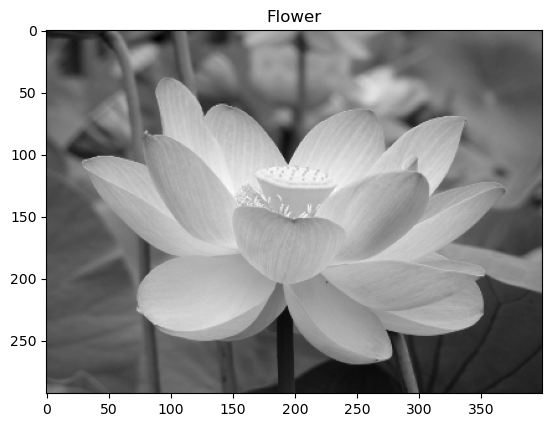

In [144]:
img_flower = cv.imread('./images/flower.png')
img_flower_gray = cv.cvtColor(img_flower, cv.COLOR_BGR2GRAY)
display_image('Flower', img_flower_gray)

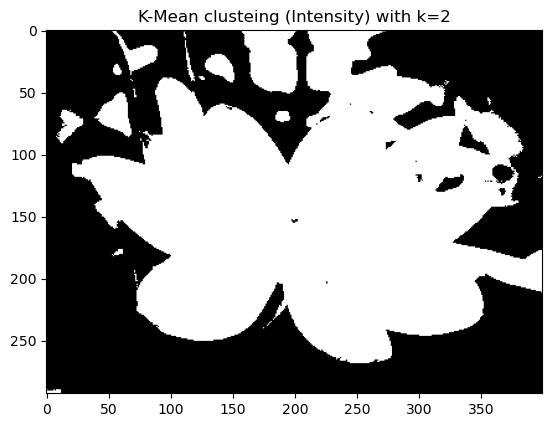

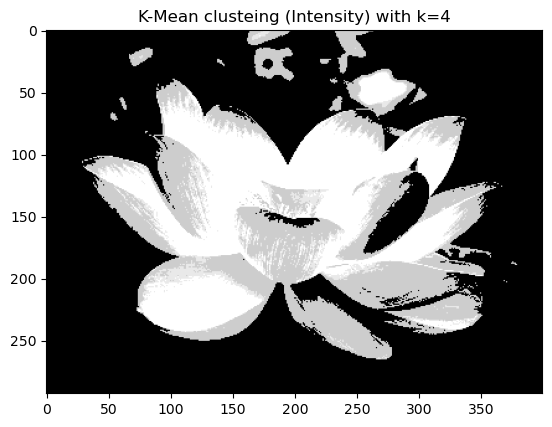

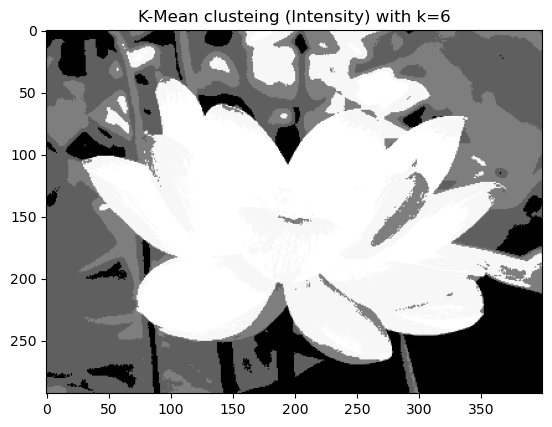

In [145]:
# reshape image to a list of pixels
data = img_flower_gray.reshape((-1, 1))
data = data.astype(np.float32)

i = 1
for k in [2, 4, 6]:
    label, center = myKmeans(data, k)
    
    center = center.astype(np.uint8)
    result = center[label.flatten()]
    
    result_img = result.reshape((img_flower_gray.shape))
    display_image(f"K-Mean clusteing (Intensity) with k={k}", result_img)

    i += 1

### Task 3b
Color

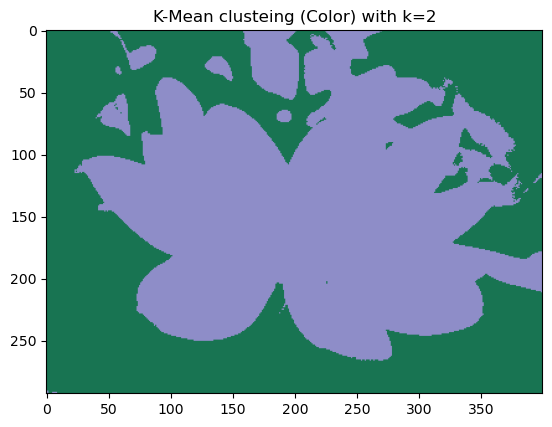

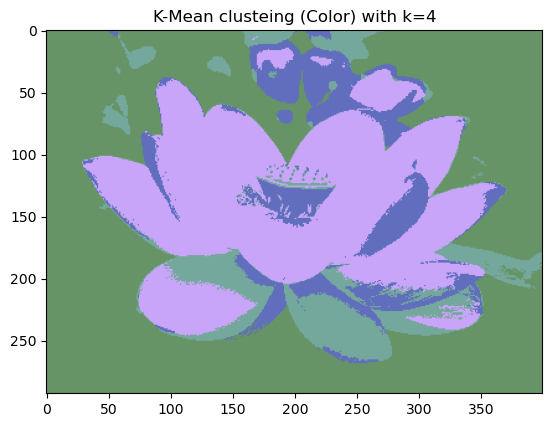

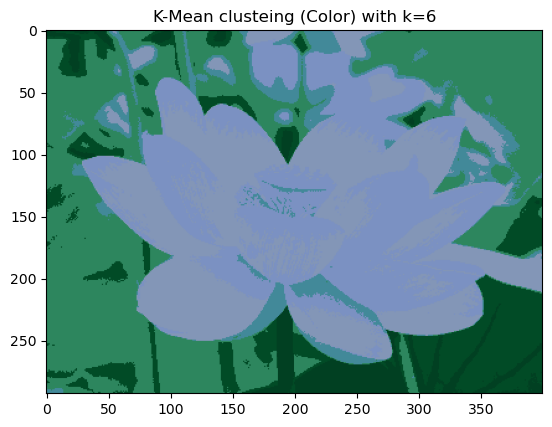

In [146]:
# reshape image to 3d lists of pixels (RGB)
data = img_flower.reshape((-1, 3))
data = data.astype(np.float32)


for k in [2, 4, 6]:
    label, center = myKmeans(data, k)
    
    center = center.astype(np.uint8)
    result = center[label.flatten()]
    
    result_img = result.reshape((img_flower.shape))
    display_image(f"K-Mean clusteing (Color) with k={k}", result_img)

    

## Task 3b
(c) Intensity and (properly scaled) image position

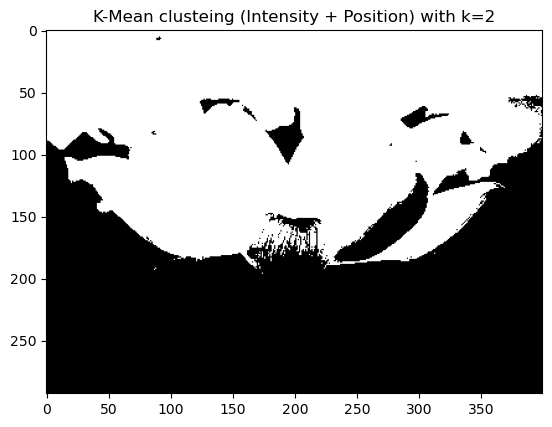

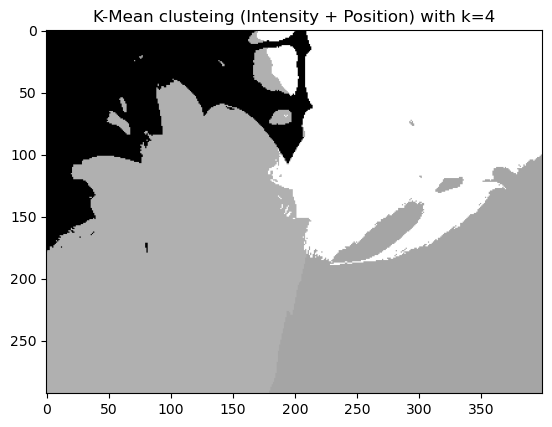

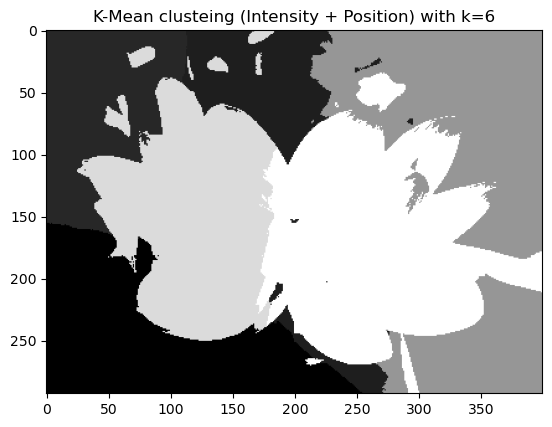

In [147]:
positions = np.indices(img_flower_gray.shape).transpose(1, 2, 0).reshape(-1, 2)
positions = np.float32(positions * 255. / np.max(positions))
# reshape image to a list of pixels
data = img_flower_gray.reshape((-1, 1))
data = data.astype(np.float32)
# store array of pixels and their positions in one array
data = np.concatenate((data, positions), axis=1) 

for k in [2, 4, 6]:
    label, center = myKmeans(data, k)
    
    center = center.astype(np.uint8)
    result = center[label.flatten()]
    
    result_img = result[:, 0].reshape((img_flower_gray.shape))
    display_image(f"K-Mean clusteing (Intensity + Position) with k={k}", result_img)

## 4.Graph Cuts

(a)  Compute the eigenvector $y$ corresponding to the second smallest eigenvalue ofthe following generalized eigenvalue problem

$$(D−W)y=λDy$$

where $W$ is the affinity matrix of the graph and $D$ is a diagonal matrix that contains the degrees of the vertices.
<div style="padding-left: 400px">
<img src='./images/graph.png' width="600" >
</div>

Hint: use cv2.eigen to solve the equivalent standard eigenvalue problem
$$
D^{−1/2}(D−W)D^{−1/2}z=λz; \quad 
z=D^{1/2}y
$$

Let's build the $D$-matrix and $W$-matrix based on the graph. Rows and cols correspond to nodes in alphabetic order. The values of $D$ on the diagonal are equal sum of weights of edges that come to the node 

In [148]:
D = [[2.2, 0, 0, 0, 0, 0, 0, 0],
     [0, 2.1, 0, 0, 0, 0, 0, 0],
     [0, 0, 2.6, 0, 0, 0, 0, 0],
     [0, 0, 0, 3.0, 0, 0, 0, 0],
     [0, 0, 0, 0, 3.0, 0, 0, 0],
     [0, 0, 0, 0, 0, 3.0, 0, 0],
     [0, 0, 0, 0, 0, 0, 3.3, 0],
     [0, 0, 0, 0, 0, 0, 0,   2]
    ]

W = [[0, 1., .2, 1., 0, 0, 0, 0],
     [1., 0, .1, 0, 1., 0, 0, 0],
     [.2, .1, 0, 1, 0, 1, .3, 0],
     [1., 0, 1., 0, 0, 1., 0, 0],
     [0, 1., 0, 0, 0, 0, 1., 1.],
     [0, 0, 1., 1., 0, 0, 1., 0],
     [0, 0, .3, 0, 1, 1., 0, 1.],
     [0, 0, 0, 0, 1., 0, 1., 0.]
    ]

D = np.array(D)
W = np.array(W)

invSqrtD = np.linalg.inv(np.sqrt(D))

L = np.matmul(np.matmul(invSqrtD, (D-W)), invSqrtD)

# calculate eigenvalues and eigenvectors with cv.eigen
retval, eigenvalues, eigenvectors = cv.eigen(L)

z = eigenvectors
y = np.matmul(invSqrtD, z)
# print the second smallest eigenvector
print(y[-2])

[-0.13209535  0.0503975  -0.19504592 -0.24930618  0.26130075 -0.14527607
  0.17010498  0.25401931]


(b)  Use the result of part (a) to find the minimum normalized cut NCut(C1,C2).  <br />
The sign of the values in the eigenvector computed in (a) determine the separation of the vertices into the two clusters C1,C2.   <br />
List the nodes in each clusterand compute the cost of the normalized cut.

In [149]:
print(y[-2] > 0)

[False  True False False  True False  True  True]


$C1 = \{B, E, G, H\}$ <br>
$C2 = \{A, C, D, F\}$ <br>


$Cut(C1, C2) = 1 + 0.1 + 0.3 + 1 = 2.4$

$NormCut(C1, C2) = \frac{2.4}{2.1 + 3 + 3.3 + 2} + \frac{2.4}{2.2 + 2.6 + 3 + 3} = 0.452991452991453 $

In [150]:
2.4/(2.1 + 3 + 3.3 + 2) + 2.4/(2.2 + 2.6 + 3 + 3)

0.452991452991453